In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importar librerias y módulos necesarios:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
path = "/content/drive/MyDrive/TFM/M_TUR_MEDIO_2017_2024.csv"
df = pd.read_csv(path)
df.head(10)

,comunidad_id,provincia_id,provincias,año,cero,b,c,eco,sin distintivo
0,16,1,araba/álava,2017,36,171,6600,364,80
1,16,1,araba/álava,2018,47,191,6669,499,60
2,16,1,araba/álava,2019,46,125,6356,632,54
3,16,1,araba/álava,2020,179,84,4780,988,31
4,16,1,araba/álava,2021,339,94,3716,1477,32
5,16,1,araba/álava,2022,505,125,2763,1264,17
6,16,1,araba/álava,2023,517,120,2620,1482,176
7,16,1,araba/álava,2024,457,141,2032,2085,189
8,8,2,albacete,2017,11,191,5651,287,299
9,8,2,albacete,2018,20,298,6025,358,59


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   comunidad_id    416 non-null    int64 
 1   provincia_id    416 non-null    int64 
 2   provincias      416 non-null    object
 3   año             416 non-null    int64 
 4   cero            416 non-null    int64 
 5   b               416 non-null    int64 
 6   c               416 non-null    int64 
 7   eco             416 non-null    int64 
 8   sin distintivo  416 non-null    int64 
dtypes: int64(8), object(1)
memory usage: 29.4+ KB
None


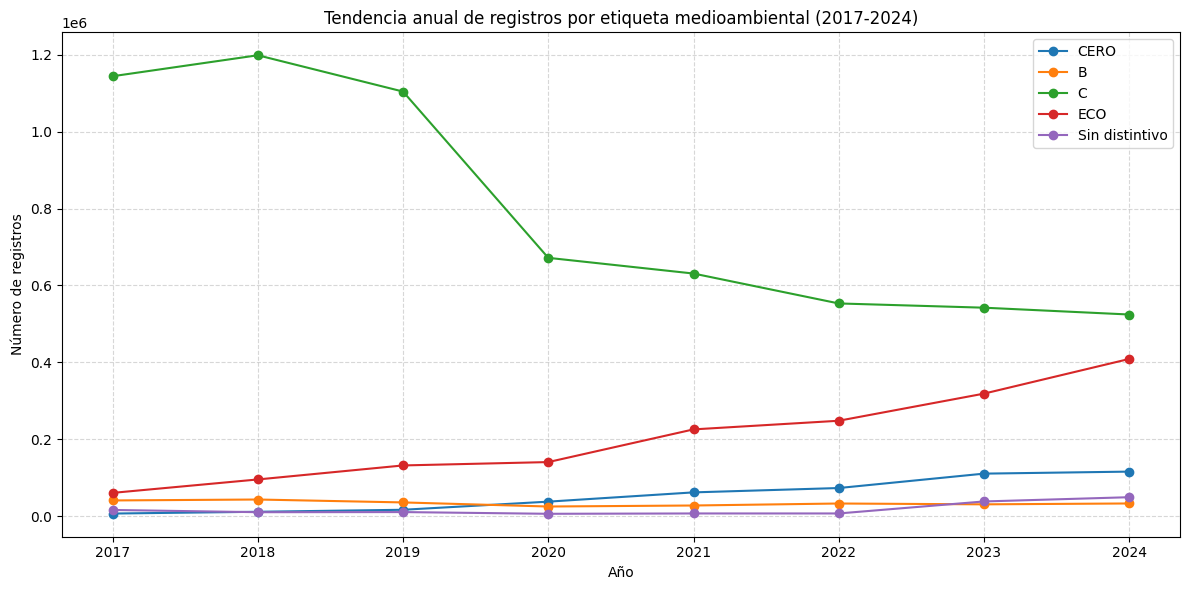

In [ ]:
# 1. Agrupación anual de registros por etiqueta medioambiental
yearly_sum = df.groupby("año")[["cero", "b", "c", "eco", "sin distintivo"]].sum().reset_index()

# visualización de tendencias anuales
plt.figure(figsize=(12, 6))
plt.plot(yearly_sum["año"], yearly_sum["cero"], marker="o", label="CERO")
plt.plot(yearly_sum["año"], yearly_sum["b"], marker="o", label="B")
plt.plot(yearly_sum["año"], yearly_sum["c"], marker="o", label="C")
plt.plot(yearly_sum["año"], yearly_sum["eco"], marker="o", label="ECO")
plt.plot(yearly_sum["año"], yearly_sum["sin distintivo"], marker="o", label="Sin distintivo")
plt.title("Tendencia anual de registros por etiqueta medioambiental (2017-2024)")
plt.xlabel("Año")
plt.ylabel("Número de registros")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Cargar librerias necesarias
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

In [ ]:
# Creación de variable objetivo
df["nuevo_energia"] = df["cero"] + df["eco"]

# Definición de features y target
features = ["año", "provincia_id", "b", "c", "sin distintivo"]
target = "nuevo_energia"

# División temporal de datos:
# Datos de entrenamiento
train = df[df["año"] < 2024]
# Datos de validación
val = df[df["año"] == 2024]

# Ordenamiento temporal
X_train, y_train = train[features], train[target]
X_val, y_val = val[features], val[target]

# Ordenar Dataframe por año
df = df.sort_values("año")

# Función de evaluación SMAPE (Error Porcentual Absoluto Medio Simétrico)
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-9))

In [ ]:
# Configuración de validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Definición del modelo y espacio de hiperparámetros
rf = RandomForestRegressor(random_state=42)
params_rf = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "max_features": ["sqrt"]
}

# Búsqueda de hiperparámetros con GridSearchCV
grid_rf = GridSearchCV(rf, params_rf, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Obtener el mejor modelo entrenado
best_rf = grid_rf.best_estimator_

# Cálculo de métricas
y_pred_rf = best_rf.predict(X_val)

# Resultados
mae_rf = mean_absolute_error(y_val, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
smape_rf = smape(y_val, y_pred_rf)
r2_rf = r2_score(y_val, y_pred_rf)

print("======== Mejor combinación de hiperparámetros: ======== \n", grid_rf.best_params_)
print("\n")
print("======== Random Forest: ======== \n")
print(f"MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}, SMAPE: {smape_rf:.2f}%, R2: {r2_rf:.3f}")

======== Mejor combinación de hiperparámetros: ======== 
 {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}


======== Random Forest: ======== 

MAE: 3643.25, RMSE: 12821.08, SMAPE: 34.78%, R2: 0.839


In [ ]:
# Configuración de validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Definición del modelo y espacio de hiperparámetros
xgb = XGBRegressor(random_state=42, objective="reg:squarederror")
params_xgb = {
    "n_estimators": [100, 200],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.1, 0.01],
    "subsample": [0.8, 1]
}

# Búsqueda de hiperparámetros con GridSearchCV
grid_xgb = GridSearchCV(xgb, params_xgb, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1)
grid_xgb.fit(X_train, y_train)

# Obtener el mejor modelo entrenado
best_xgb = grid_xgb.best_estimator_

# Cálculo de métricas
y_pred_xgb = best_xgb.predict(X_val)

# Resultados
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
smape_xgb = smape(y_val, y_pred_xgb)
r2_xgb = r2_score(y_val, y_pred_xgb)

print("======== Mejor combinación de hiperparámetros XGBoost: ======== \n", grid_xgb.best_params_)
print("\n")
print("======== XGBoost: ======== \n")
print(f"MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}, SMAPE: {smape_xgb:.2f}%, R2: {r2_xgb:.3f}")

======== Mejor combinación de hiperparámetros XGBoost: ======== 
 {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}


======== XGBoost: ======== 

MAE: 4045.96, RMSE: 17036.79, SMAPE: 32.01%, R2: 0.716


In [ ]:
# Entrenamiento del modelo
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predicción en el conjunto de validación
y_pred_lr = lr.predict(X_val)

# Cálculo de métricas de evaluación
mae_lr = mean_absolute_error(y_val, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_val, y_pred_lr))
smape_lr = smape(y_val, y_pred_lr)
r2_lr = r2_score(y_val, y_pred_lr)

# Resultados
print("======== Linear Regression: ========")
print(f"MAE: {mae_lr:.2f}, RMSE: {rmse_lr:.2f}, SMAPE: {smape_lr:.2f}%, R2: {r2_lr:.3f}")

======== Linear Regression: ========
MAE: 5058.65, RMSE: 6763.48, SMAPE: 83.00%, R2: 0.955




---



Solo Random Forest

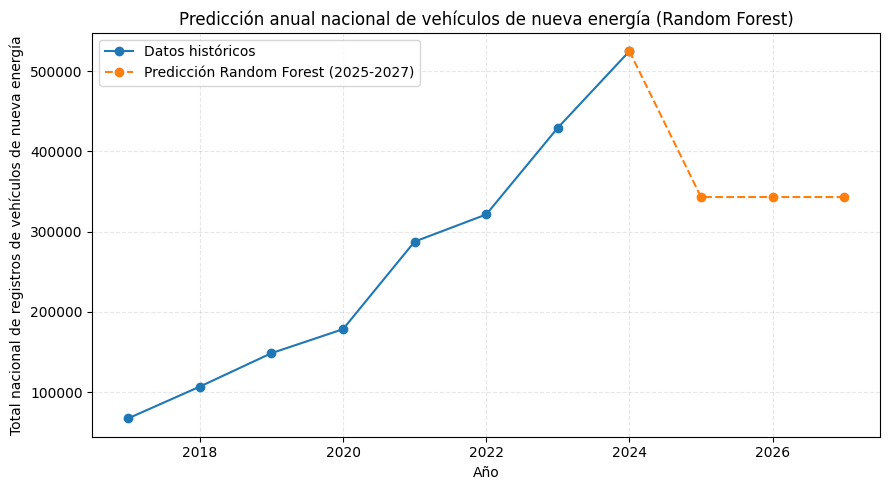

In [ ]:
# Obtener la lista única de IDs de provincia
provincia_ids = df["provincia_id"].unique()

# Obtener valores de referencia para features no predictivas (b, c, sin distintivo)
b_val = df["b"].mean()
c_val = df["c"].mean()
sin_dist_val = df["sin distintivo"].mean()

# Construcción del dataframe de predicción
future_years = [2025, 2026, 2027]
future_rows = []
for año in future_years:
    for provincia_id in provincia_ids:
        future_rows.append({
            "año": año,
            "provincia_id": provincia_id,
            "b": b_val,
            "c": c_val,
            "sin distintivo": sin_dist_val
        })
future_df = pd.DataFrame(future_rows)

# Preparación de datos para Random Forest
features = ["año", "provincia_id", "b", "c", "sin distintivo"]
X_future = future_df[features]

# Preducción con el modelo Random Forest
future_df["nuevo_energia_pred"] = grid_rf.predict(X_future)

# Cálculo de totales nacionales
future_total = future_df.groupby("año")["nuevo_energia_pred"].sum().reset_index()
future_total = future_total.rename(columns={"nuevo_energia_pred":"nuevo_energia"})

# Datos históricos (2017-2024)
yearly_hist = df.groupby("año")["nuevo_energia"].sum().reset_index()

# Combinación histórica + predicciones
yearly_all = pd.concat([yearly_hist, future_total], ignore_index=True)
yearly_all = yearly_all.sort_values("año").reset_index(drop=True)
yearly_all["is_pred"] = yearly_all["año"] >= 2025

# Visualización de resultados
plt.figure(figsize=(9,5))
hist = yearly_all[~yearly_all["is_pred"]]
plt.plot(hist["año"], hist["nuevo_energia"], "o-", color="tab:blue", label="Datos históricos")
pred = yearly_all[yearly_all["is_pred"]]
año_pred = [hist.iloc[-1]["año"]] + pred["año"].tolist()
nuevo_pred = [hist.iloc[-1]["nuevo_energia"]] + pred["nuevo_energia"].tolist()
plt.plot(año_pred, nuevo_pred, "o--", color="tab:orange", label="Predicción Random Forest (2025-2027)")
plt.xlabel("Año")
plt.ylabel("Total nacional de registros de vehículos de nueva energía")
plt.title("Predicción anual nacional de vehículos de nueva energía (Random Forest)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

Solo Linear Regression

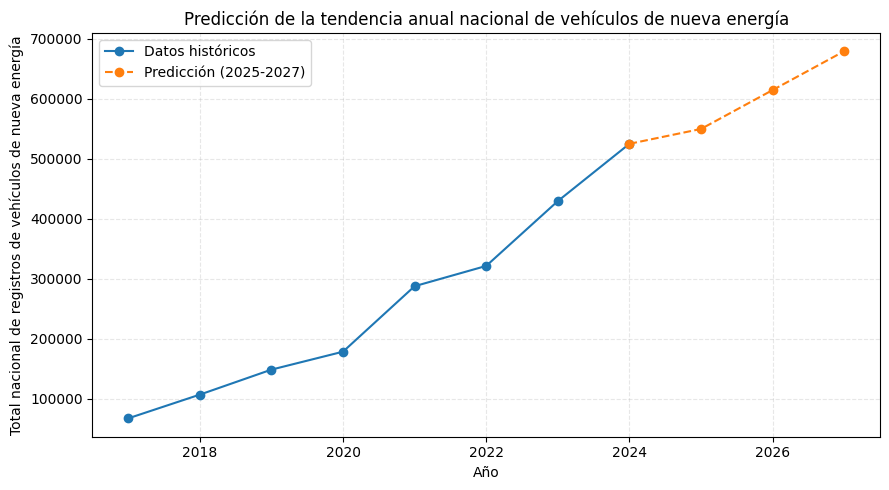

In [ ]:
# Calcular el total anual nacional de registros de vehículos de nueva energía
yearly = df.groupby("año")["nuevo_energia"].sum().reset_index()

# Entrenar la regresión lineal solo con el año como variable
X_year = yearly["año"].values.reshape(-1, 1)
y_year = yearly["nuevo_energia"].values
lr_year = LinearRegression()
lr_year.fit(X_year, y_year)

# Predecir la tendencia para los años 2025-2027
future_years = np.array([2025, 2026, 2027]).reshape(-1, 1)
trend_pred = lr_year.predict(future_years)

# Unir los resultados históricos y las predicciones para su visualización o análisis posterior
forecast_years = pd.DataFrame({
    "año": [2025, 2026, 2027],
    "nuevo_energia": trend_pred
})

# Preparación de datos para visualización
yearly_all["año"] = yearly_all["año"].astype(int)
yearly_all = yearly_all.sort_values("año").reset_index(drop=True)
yearly_all["is_pred"] = yearly_all["año"] >= 2025

# Datos históricos (2017-2024)
hist = yearly_all[~yearly_all["is_pred"]]
plt.plot(hist["año"], hist["nuevo_energia"], "o-", color="tab:blue", label="Datos históricos")

# Predicciones
last_hist_year = hist.iloc[-1]["año"]
last_hist_value = hist.iloc[-1]["nuevo_energia"]
pred = yearly_all[yearly_all["is_pred"]]
año_pred = [last_hist_year] + pred["año"].tolist()
nuevo_pred = [last_hist_value] + pred["nuevo_energia"].tolist()
plt.plot(año_pred, nuevo_pred, "o--", color="tab:orange", label="Predicción (2025-2027)")

# Visualización de la tendencia
plt.figure(figsize=(9,5))
plt.xlabel("Año")
plt.ylabel("Total nacional de registros de vehículos de nueva energía")
plt.title("Predicción de la tendencia anual nacional de vehículos de nueva energía")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

Linear Regression + Random Forest

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


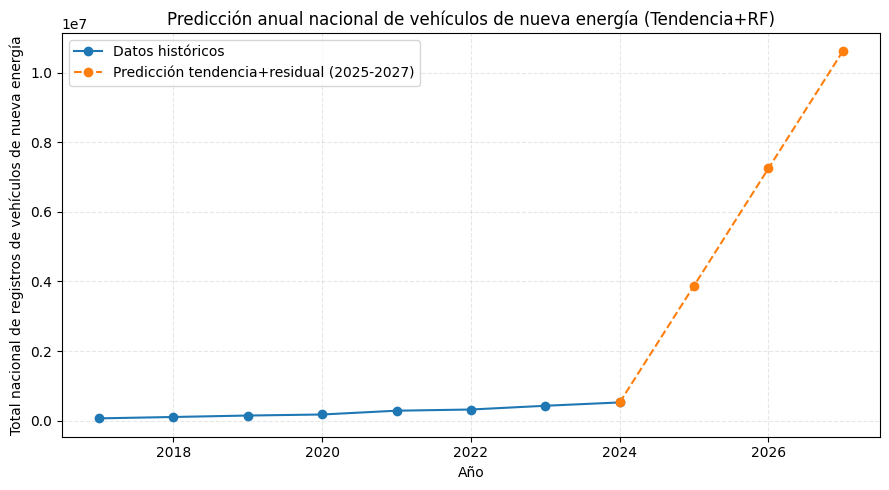

In [ ]:
# Preparar datos para predicción de tendencia
X_year = yearly_hist["año"].values.reshape(-1, 1)
# Predecir valores de tendencia para aós históricos
trend_pred_hist = lr_year.predict(X_year)

# Calcular residuos
yearly_hist["residual"] = yearly_hist["nuevo_energia"] - trend_pred_hist

# Construir conjunto de entrenamiento para modelo de residuos
# Mapear tendencia por año
df["trend"] = df["año"].map(dict(zip(yearly_hist["año"], trend_pred_hist)))
df["residual"] = df["nuevo_energia"] - df["trend"]

# Seleccionar características para el modelo de residuos
features = ["año", "provincia_id", "b", "c", "sin distintivo"]
X_res = df[features]
y_res = df["residual"]

# Entrenar modelo Random Forest para predecir residuos
rf_res = RandomForestRegressor()
rf_res.fit(X_res, y_res)

# Preparar DataFrame futuro (predicciones 2025-2027)
future_df["trend_pred"] = lr_year.predict(future_df[["año"]])

# Predecir residuos para datos futuros usando el modelo RF
X_future_res = future_df[features]
future_df["residual_pred"] = rf_res.predict(X_future_res)

# Calcular predicción final (tendencia + residuo)
future_df["final_pred"] = future_df["trend_pred"] + future_df["residual_pred"]

# Consolidar predicciones futuras a nivel nacional
future_total = future_df.groupby("año")["final_pred"].sum().reset_index()
future_total = future_total.rename(columns={"final_pred":"nuevo_energia"})

# Combinar datos históricos y predicciones
yearly_all = pd.concat([yearly_hist[["año","nuevo_energia"]], future_total], ignore_index=True)
yearly_all = yearly_all.sort_values("año").reset_index(drop=True)
yearly_all["is_pred"] = yearly_all["año"] >= 2025

# Graficar predicciones
plt.figure(figsize=(9,5))
hist = yearly_all[~yearly_all["is_pred"]]
plt.plot(hist["año"], hist["nuevo_energia"], "o-", color="tab:blue", label="Datos históricos")
pred = yearly_all[yearly_all["is_pred"]]
año_pred = [hist.iloc[-1]["año"]] + pred["año"].tolist()
nuevo_pred = [hist.iloc[-1]["nuevo_energia"]] + pred["nuevo_energia"].tolist()
plt.plot(año_pred, nuevo_pred, "o--", color="tab:orange", label="Predicción tendencia+residual (2025-2027)")
plt.xlabel("Año")
plt.ylabel("Total nacional de registros de vehículos de nueva energía")
plt.title("Predicción anual nacional de vehículos de nueva energía (Tendencia+RF)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


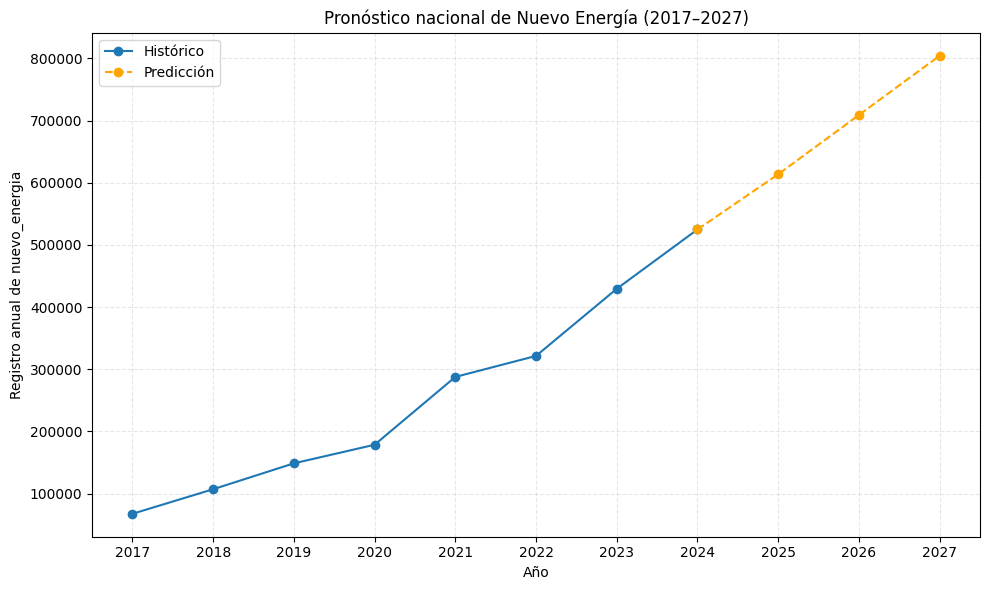

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Preparar serie temporal anual a nivel nacional
# Sumar vehículos ecológicos y de cero emisiones para obtener el total de "nuevo_energia"
df["nuevo_energia"] = df["cero"] + df["eco"]
# Agrupar por año y sumar todos los registros nacionales
yearly = df.groupby("año")["nuevo_energia"].sum().reset_index()

# Crear una serie temporal con índice de año
ts = yearly.set_index("año")["nuevo_energia"]

# Ajustar modelo Holt's Linear Trend
model = ExponentialSmoothing(ts, trend="add", seasonal=None).fit()

# Realizar pronóstico para 3 años (2025-2027)
forecast_years = [2025, 2026, 2027]
forecast = model.forecast(3)
forecast.index = forecast_years
forecast = forecast.round().astype(int)

# Visualización del pronóstico
plt.figure(figsize=(10,6))
# Graficar datos históricos (2017-2024)
plt.plot(ts.index, ts.values, "o-", color="#1f77b4", label="Histórico")

# Graficar pronóstico (2025-2027) conectado al último punto histórico (2024)
x_pred = [2024] + forecast_years
y_pred = [ts.loc[2024]] + list(forecast.values)
plt.plot(x_pred, y_pred, "o--", color="orange", label="Predicción")

# Configuración del gráfico
plt.title("Pronóstico nacional de Nuevo Energía (2017–2027)")
plt.xlabel("Año")
plt.ylabel("Registro anual de nuevo_energia")
plt.xticks(list(ts.index) + forecast_years)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Calcular total de vehículos de nueva energía por provincia
df["nuevo_energia"] = df["cero"] + df["eco"]

# Años futuros a pronosticar
future_years = [2025, 2026, 2027]
result_list = []

# Procesar cada provincia individualmente
for pid, subdf in df.groupby('provincia_id'):
    # Ordenar datos por año y obtener nombre de provincia
    subdf = subdf.sort_values('año')
    provincia = subdf['provincias'].iloc[0]
    # Preparar serie temporal
    ts = subdf.set_index('año')['nuevo_energia']
    # Modelado con manejo de errores para provincias con pocos datos
    try:
        model = ExponentialSmoothing(ts, trend='add', seasonal=None, initialization_method='estimated')
        fit = model.fit()
        forecast = fit.forecast(len(future_years))
    except:
        # Fallback para provincias con datos insuficientes: usar último valor conocido
        forecast = pd.Series([ts.iloc[-1]] * len(future_years), index=future_years)

    # Combinar datos históricos y pronósticos
    all_years = list(ts.index) + future_years
    all_values = list(ts.values) + list(forecast)
    all_type = ['histórico']*len(ts) + ['predicción']*len(future_years)

    # Almacenar resultados en formato tidy
    for y, v, t in zip(all_years, all_values, all_type):
        result_list.append({
            "provincia_id": pid,
            "provincias": provincia,
            "año": y,
            "nuevo_energia": int(round(v)),
            "tipo": t
        })

# Crear DataFrame con todos los resultados
df_forecast = pd.DataFrame(result_list)

# Guardar resultados en CSV para crear mapas de datos en Tableau
output_path = "/content/drive/MyDrive/TFM/provincia_nuevo_energia_forecast_2017_2027.csv"
df_forecast.to_csv(output_path, index=False)

# Mostrar vista previa
print(f"Archivo está guardado: {output_path}")
print(df_forecast.head(10))